In [1]:
import math
from abc import abstractmethod
import torch
import gpytorch
import tqdm
from matplotlib import pyplot as plt
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from torchdiffeq import odeint
from torch.nn import Parameter
from torch.distributions import Independent, Normal

from lafomo.datasets import P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.variational.models import VariationalLFM

In [2]:
class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, num_latents):
        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        # We have to wrap the VariationalStrategy in a MultitaskVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ), num_tasks=num_latents
        )

        super().__init__(variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ZeroMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents]))

    def forward(self, t):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(t)
        covar_x = self.covar_module(t)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



class OrdinaryLFM(VariationalLFM):
    """
    Variational approximation for an LFM based on an ordinary differential equation (ODE).
    Inheriting classes must override the `odefunc` function which encodes the ODE.
    """

    # def __init__(self, num_latent, config: VariationalConfiguration, kernel, t_inducing, dataset: LFMDataset, dtype=torch.float64):
        # super().__init__(num_latent, config, kernel, t_inducing, dataset, dtype)
    def __init__(self, config: VariationalConfiguration, dataset, dtype=torch.float64):
        self.config = config
        super().__init__(config, dataset, dtype=dtype)
        self.nfe = 0
        self.f = None

    def initial_state(self):
        initial_state = torch.zeros(torch.Size([self.num_outputs, 1]), dtype=torch.float64)
        initial_state = initial_state.cuda() if is_cuda() else initial_state
        return initial_state.repeat(self.config.num_samples, 1, 1)  # Add batch dimension for sampling
        # if self.options.initial_conditions: TODO:
        #     h = self.initial_conditions.repeat(h.shape[0], 1, 1)

    def forward(self, t, q_f, step_size=1e-1, return_samples=False):
        """
        t : torch.Tensor
            Shape (num_times)
        h : torch.Tensor the initial state of the ODE
            Shape (num_genes, 1)
        Returns
        -------
        Returns evolved h across times t.
        Shape (num_genes, num_points).
        """
        self.nfe = 0

        # Integrate forward from the initial positions h0.
        h0 = self.initial_state()
        h0 = h0.unsqueeze(0).repeat(self.options.num_samples, 1, 1)
        self.f = q_f.rsample(torch.Size([self.options.num_samples])).permute(0, 2, 1)  # (S, I, T)
        self.f = self.G(self.f)
        # print('de_model forward', self.f.shape)
        # print(self.f.shape)
        self.t_index = 0
        self.last_t = self.f.min()-1
        h_samples = odeint(self.odefunc, h0, t, method='rk4', options=dict(step_size=step_size))#, rtol=rtol, atol=atol)  # (T, S, num_outputs, 1)

        self.f = None
        # self.t_index = None
        # self.last_t = None
        if return_samples:
            return h_samples

        h_out = torch.mean(h_samples, dim=1).permute(1, 0, 2).reshape(-1) # shape was (#outputs, #T, 1)
        h_var = torch.var(h_samples, dim=1).permute(1, 0, 2).reshape(-1) + 1e-7

        h_out = self.decode(h_out)
        # print('h_out', h_out.shape, h_var.shape)
        # TODO: make distribution something less constraining
        # print(h_var.min(), h_var)
        h_covar = torch.diag(h_var)
        q = gpytorch.distributions.MultivariateNormal(h_out, h_covar)
        return q

    def decode(self, h_out):
        return h_out

    @abstractmethod
    def odefunc(self, t, h):
        """
        Parameters:
            h: shape (num_samples, num_outputs, 1)
        """
        pass

    @abstractmethod
    def G(self, f):
        return f.repeat(1, self.num_outputs, 1)  # (S, I, t)


class TranscriptionalRegulationLFM(OrdinaryLFM):
    def __init__(self, config: VariationalConfiguration, dataset):
        super().__init__(config, dataset)
        self.decay_rate = Parameter(0.1 + torch.rand((self.num_outputs, 1), dtype=torch.float64))
        self.basal_rate = Parameter(torch.rand((self.num_outputs, 1), dtype=torch.float64))
        self.sensitivity = Parameter(0.2 + torch.rand((self.num_outputs, 1), dtype=torch.float64))

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)

        decay = self.decay_rate * h

        f = self.f[:, :, self.t_index].unsqueeze(2)

        h = self.basal_rate + self.sensitivity * f - decay
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return h

In [21]:
from lafomo.variational.trainer import Trainer
from lafomo.utilities.torch import is_cuda


class NewTrainer(Trainer):
    def __init__(self, gp_model: gpytorch.models.GP, de_model, optimizer: torch.optim.Optimizer, dataset):
        super().__init__(gp_model, de_model, optimizer, dataset, batch_size=de_model.num_outputs)

    def single_epoch(self, rtol, atol):
        data = next(iter(self.data_loader))

        self.optimizer.zero_grad()
        t, y = data
        t = t.cuda() if is_cuda() else t
        y = y.cuda() if is_cuda() else y
        # Assume that the batch of t s are the same
        t, y = t[0].view(-1), y

        # with ef.scan():
        t_f = torch.arange(t.min(), t.max()+step_size/3, step_size/3)
        # print('feeding gp with ', t_f.shape)
        f_output = self.gp_model(t_f)
        # print('fout', f_output)

        g_output = self.de_model(t, f_output, step_size=1e-1)

        # Calc loss and backprop gradients
        #  log_likelihood - kl_divergence + log_prior - added_loss
        log_likelihood, kl_divergence, _ = mll(g_output, y.view(-1))

        loss = - (log_likelihood - kl_divergence)

        loss.backward()
        self.optimizer.step()

        return loss, (-log_likelihood, kl_divergence)

In [32]:
dataset = P53Data(replicate=0, data_dir='../data')
num_genes = 5
num_tfs = 1
config = VariationalConfiguration(
    preprocessing_variance=dataset.variance,
    learn_inducing=False,
    num_samples=70,
    kernel_scale=False,
    initial_conditions=False
)

# The shape of the inducing points should be (2 x m x 1) - so that we learn different inducing
# points for each output
num_inducing = 12
inducing_points = torch.linspace(0, 12, num_inducing).view(num_tfs, num_inducing, 1)

gp_model = MultitaskGPModel(inducing_points, num_tfs)
de_model = TranscriptionalRegulationLFM(config, dataset)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tfs)

# Find optimal model hyperparameters
gp_model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    *gp_model.parameters(),
    *de_model.parameters()
], lr=0.08)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
num_training_points = 7 * 5
mll = gpytorch.mlls.VariationalELBO(likelihood, gp_model, num_training_points, combine_terms=False)
trainer = NewTrainer(gp_model, de_model, optimizer, dataset)

step_size = 5e-2

In [35]:
gp_model.train()
likelihood.train()

trainer.train(100, report_interval=10, rtol=step_size)

Epoch 101/200 - Loss: 1.30 (1.20  0.10  ) λ: 1.3371168375015259
Epoch 111/200 - Loss: 1.30 (1.21  0.09  ) λ: 1.4878180027008057
Epoch 121/200 - Loss: 1.29 (1.20  0.09  ) λ: 1.5825453996658325
Epoch 131/200 - Loss: 1.30 (1.21  0.09  ) λ: 1.6578046083450317
Epoch 141/200 - Loss: 1.30 (1.21  0.09  ) λ: 1.6881388425827026
Epoch 151/200 - Loss: 1.30 (1.21  0.09  ) λ: 1.7050822973251343
Epoch 161/200 - Loss: 1.29 (1.20  0.09  ) λ: 1.75022554397583
Epoch 171/200 - Loss: 1.29 (1.19  0.10  ) λ: 1.7332490682601929
Epoch 181/200 - Loss: 1.29 (1.20  0.09  ) λ: 1.7439863681793213
Epoch 191/200 - Loss: 1.29 (1.20  0.10  ) λ: 1.711625576019287


tensor([ 0.,  2.,  4.,  6.,  8., 10., 12.])
torch.Size([35])


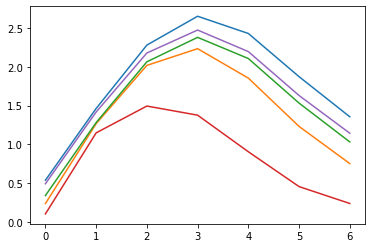

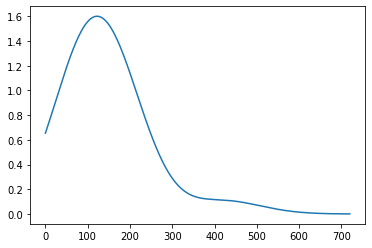

In [36]:
gp_model.eval()
likelihood.eval()

with torch.no_grad():
    data = next(iter(trainer.data_loader))
    t, y = data

    # Assume that the batch of t s are the same
    t, y = t[0].view(-1), y
    print(t)
    # with ef.scan():
    t_f = torch.arange(t.min(), t.max()+step_size/3, step_size/3)

    f_output = gp_model(t_f)

    g_output = de_model(t, f_output, step_size=1e-1)

    observed_pred = likelihood(g_output)
    print(observed_pred.mean.shape)
    obs = observed_pred.mean.view(5, 7)

    for i in range(5):
        plt.plot(obs[i])


    plt.figure()
    plt.plot(f_output.mean.squeeze())

In [6]:
print(t.shape)
gp_model.mean_module(t)

torch.Size([7])


tensor([[0., 0., 0., 0., 0., 0., 0.]])